# Weather Data Analysis

Script to analyse weather scraped from http://weather.gc.ca 

In [1]:
import os
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from platform import python_version
python_version()

'3.7.7'

In [2]:
data_dir = 'data'
plot_dir = 'plots'

if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [3]:
station_code = 'vou'
filename = f'past-24-hr-{station_code}-data.csv'

In [4]:
def read_data_from_file(data_dir, year, filename):
    filepath = os.path.join(data_dir, f"{year:d}", filename)
    df = pd.read_csv(filepath)
    return df

def save_data_to_file(df, data_dir, year, filename):
    filepath = os.path.join(data_dir, f"{year:d}", filename)
    df = pd.read_csv(filepath)
    return df

In [5]:
date = datetime.datetime.now()
year = date.year
df = read_data_from_file(data_dir, year, filename)

In [6]:
df.head()

,Date / Time PST,Conditions,Temperature °C,Wind km/h,Relative %,Dew °C,Pressure kPa,Visibility km
0,2021-01-02 16:00,NaN,8 (7.8),ENE 2,99,8,99.9,NaN
1,2021-01-02 17:00,NaN,7 (7.3),E 2,100,7,100.0,NaN
2,2021-01-02 18:00,NaN,7 (6.6),N 3,100,7,100.0,NaN
3,2021-01-02 19:00,NaN,6 (6.0),E 2,100,6,100.0,NaN
4,2021-01-02 20:00,NaN,6 (5.7),ENE 6,100,6,100.1,NaN


In [7]:
df.tail()

,Date / Time PST,Conditions,Temperature °C,Wind km/h,Relative %,Dew °C,Pressure kPa,Visibility km
95,2021-01-06 15:00,NaN,8 (8.0),SE 10,87,6,101.7,NaN
96,2021-01-06 16:00,NaN,8 (7.8),SE 7,89,6,101.7,NaN
97,2021-01-06 17:00,NaN,7 (6.5),NW 6,94,6,101.7,NaN
98,2021-01-06 18:00,NaN,6 (6.2),NW 7,95,6,101.8,NaN
99,2021-01-06 19:00,NaN,6 (6.1),NW 9,94,5,101.9,NaN


In [8]:
wind_labels = sorted(df['Wind km/h'].unique().tolist())
wind_labels

['E 2',
 'ENE 2',
 'ENE 3',
 'ENE 6',
 'ESE 11',
 'ESE 12',
 'ESE 13',
 'ESE 14',
 'ESE 15',
 'ESE 17',
 'ESE 17 gust 27',
 'ESE 17 gust 29',
 'ESE 18 gust 27',
 'ESE 21',
 'ESE 22 gust 34',
 'ESE 22 gust 36',
 'ESE 22 gust 45',
 'ESE 23 gust 34',
 'ESE 24 gust 41',
 'ESE 24 gust 43',
 'ESE 28 gust 46',
 'ESE 29 gust 57',
 'ESE 30 gust 50',
 'ESE 32 gust 46',
 'ESE 32 gust 56',
 'ESE 33 gust 51',
 'ESE 36 gust 51',
 'ESE 5',
 'ESE 6',
 'ESE 7',
 'ESE 8',
 'ESE 9',
 'N 10',
 'N 2',
 'N 3',
 'N 4',
 'NE 6',
 'NE 7',
 'NNW 11',
 'NNW 3',
 'NNW 5',
 'NNW 6',
 'NW 3',
 'NW 5',
 'NW 6',
 'NW 7',
 'NW 9',
 'SE 10',
 'SE 11',
 'SE 13',
 'SE 13 gust 27',
 'SE 15',
 'SE 15 gust 31',
 'SE 16',
 'SE 17',
 'SE 17 gust 31',
 'SE 18',
 'SE 18 gust 29',
 'SE 18 gust 35',
 'SE 19 gust 29',
 'SE 21 gust 30',
 'SE 22 gust 37',
 'SE 24 gust 36',
 'SE 24 gust 41',
 'SE 24 gust 43',
 'SE 25 gust 35',
 'SE 26 gust 35',
 'SE 26 gust 52',
 'SE 3',
 'SE 32 gust 49',
 'SE 34 gust 49',
 'SE 35 gust 48',
 'SE 4',


In [9]:
def find_re_match(text, patterns):
    for i, pattern in enumerate(patterns):
        match = re.match(pattern, text)
        if match:
            return i, match
    else:
        return None, None


valid_patterns = [
    r'^\s*calm\s*$',
    r'^\s*[A-Z]+\s+\d+\s*$',
    r'^\s*[A-Z]+\s+\d+\s+gust\s+\d+\s*$'
]

wind_directions = {
    'N': 0,
    'NNE': 22.5,
    'NE': 45,
    'ENE': 67.5,
    'E': 90,
    'ESE': 112.5,
    'SE': 135,
    'SSE': 157.5,
    'S': 180,
    'SSW': 202.5,
    'SW': 225,
    'WSW': 247.5,
    'W': 270,
    'WNW': 292.5,
    'NW': 315,
    'NNW': 337.5
}


def parse_wind_description(text):
    """Parses a wind description string such as 'ENE 2' or
    'SE 32 gust 49' and returns the following data items as
    a dictionary: {
        'Direction': direction, 
        'Degrees': degrees,
        'Speed (km/h)': speed, 
        'Label': 'gust', gust_speed
        'Data': data
    }.
    """
    i, match = find_re_match(text, valid_patterns)
    if not match:
        return None, None, None, None
    text = match.group()
    if i == 0:
        direction, degrees, speed = None, None, 0
        label, data = None, None
    elif i == 1:
        words = text.split()
        direction = words[0]
        degrees = wind_directions[direction]
        speed = int(words[1])
        label, data = None, None
    elif i == 2:
        words = text.split()
        direction = words[0]
        degrees = wind_directions[direction]
        speed = int(words[1])
        label = words[2]
        data = int(words[3])
        assert label == 'gust'
    return {
        'Direction': direction, 
        'Degrees': degrees, 
        'Speed (km/h)': speed, 
        'Label': label,
        'Data': data
    }

assert parse_wind_description('calm') == \
    {'Direction': None, 'Degrees': None, 'Speed (km/h)': 0, 'Label': None, 'Data': None}
assert parse_wind_description('N 10') == \
    {'Direction': 'N', 'Degrees': 0, 'Speed (km/h)': 10, 'Label': None, 'Data': None}
assert parse_wind_description(' ENE  13  ') == \
    {'Direction': 'ENE', 'Degrees': 67.5, 'Speed (km/h)': 13, 'Label': None, 'Data': None}
assert parse_wind_description(' NNW   34 gust 45') == \
    {'Direction': 'NNW', 'Degrees': 337.5, 'Speed (km/h)': 34, 'Label': 'gust', 'Data': 45}

In [10]:
wind_data = pd.DataFrame.from_records(df['Wind km/h'].apply(parse_wind_description), index=df['Date / Time PST'])
wind_data

,Direction,Degrees,Speed (km/h),Label,Data
Date / Time PST,,,,,
2021-01-02 16:00,ENE,67.5,2,None,NaN
2021-01-02 17:00,E,90.0,2,None,NaN
2021-01-02 18:00,N,0.0,3,None,NaN
2021-01-02 19:00,E,90.0,2,None,NaN
2021-01-02 20:00,ENE,67.5,6,None,NaN
...,...,...,...,...,...
2021-01-06 15:00,SE,135.0,10,None,NaN
2021-01-06 16:00,SE,135.0,7,None,NaN
2021-01-06 17:00,NW,315.0,6,None,NaN


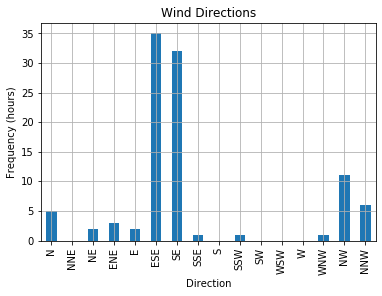

In [11]:
wind_data['Direction'].value_counts().reindex(wind_directions.keys()).plot.bar()
plt.grid()
plt.title('Wind Directions')
plt.xlabel('Direction')
plt.ylabel('Frequency (hours)')
plt.show()

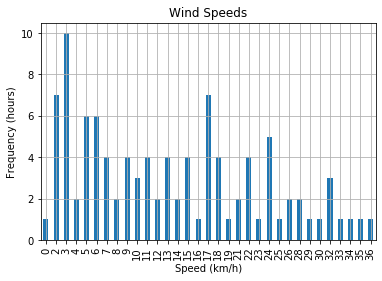

In [12]:
wind_data['Speed (km/h)'].value_counts().sort_index().plot.bar()
plt.grid()
plt.title('Wind Speeds')
plt.ylabel('Frequency (hours)')
plt.xlabel('Speed (km/h)')
plt.show()

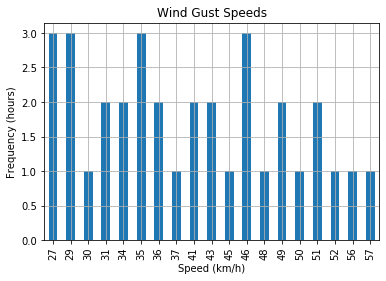

In [13]:
wind_data.loc[wind_data.Label == 'gust', 'Data'].astype(int).value_counts().sort_index().plot.bar()
plt.grid()
plt.title('Wind Gust Speeds')
plt.ylabel('Frequency (hours)')
plt.xlabel('Speed (km/h)')
plt.show()

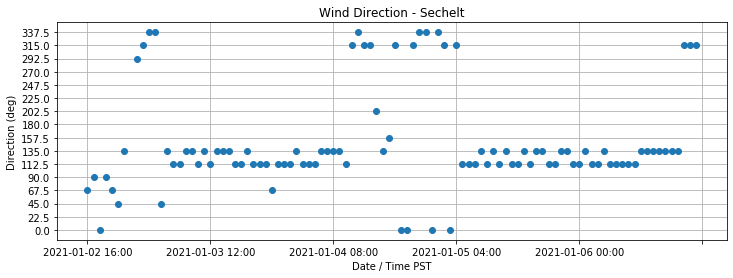

In [18]:
plt.figure(figsize=(12, 4))
wind_data['Degrees'].plot(style='o')
plt.title('Wind Direction - Sechelt')
plt.yticks(np.arange(0, 360, 22.5))
plt.ylabel('Direction (deg)')
plt.grid()
filename = f'{station_code}-wind-direction-time-plot.png'
plt.savefig(os.path.join(plot_dir, filename), dpi=300)
plt.show()